# Oligopoly-Cartel V2

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import support_functions as sf
#main model classses
from market import Market
from bank import Bank
from customer_group import Customer_group

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


# Variables

In [30]:
time_steps = 2

#Market setting
score_range = [300,850]
repay_score = 75
default_score = -150

#initial interest rate setting
initial_interest_rate_range = [0.14, 0.06]

#this correspends to selection rate(perfect competition [0,1]) or to loan demand (oligopoly [0, x<1])
plane_range = [0, 1]
plane_slice_step = 0.01

#demand and supply interest rate boundaries
max_interest_rate_range = [0.15, 0.1]
min_interest_rate_range = [0.01, 0.001]

#policy
selected_policy = 0  #0=MU, 1=DP , 2=EO 
policy_names = ["Max. utility", "Dem. parity", "Equal opportunity" ]
policy_colors = ['green', 'blue', 'red']

#Bank setting
bank_line_style = ['-.']
bank_color = ['blue']
#number of banks in the market
N_banks = 2

#bank score distribution shift(same number of shifts as number of banks)
score_shifts = [0, -20]

# profit and impact for banks (same for every bank, but different profit and impact can be set for each bank and model different revenue/cost "function")
utility_repaid = 1
utility_default = -3

#Customer groups setting
#use unique names
group_names = ["White","Black"]
group_colors = ['grey', 'black']
group_line_style = ['-',':']

#estimated number of customers in each group
white_totals = 8800
black_totals = 1200
loan_demand = 0.1

error_rate = 0
score_error = 0

# Prepare initial data

In [31]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

repays = performance[group_names]

totals = fico.read_totals(data_dir=DATA_DIR)
##### comment to use dataset totals (too many people)
totals['White'] = white_totals
totals['Black'] = black_totals
####
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
customer_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    customer_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(customer_totals))

#demographic statistics 
group_ratio = np.array((customer_totals[0], customer_totals[1]))
group_size_ratio = group_ratio/group_ratio.sum()
print("Group size ratio: " + str(group_size_ratio))

pis_total = np.round(pis*group_totals[:, None])

ref_customer_scores = sf.get_ref_customers(customer_totals, pis_total, scores_list)

Reference group totals: [8800 1200]
Calculated group totals: [8805 1193]
Group size ratio: [ 0.88067614  0.11932386]


../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


# Create Model

In [32]:
#create market
market = Market(policy_names[selected_policy], policy_colors[selected_policy], score_range = score_range ,repay_score = repay_score, default_score = default_score, max_interest_rate_range = max_interest_rate_range, min_interest_rate_range = min_interest_rate_range, plane_slice_step = plane_slice_step)

banks= []
for i in range(0,N_banks):
    banks.append(Bank("bank_%02d" % i, bank_color[0],bank_line_style[0], initial_interest_rate_range, market, score_shifts[i]))

white_group = Customer_group(group_names[0], group_colors[0], group_line_style[0], customer_totals[0], ref_customer_scores[0], loan_demand, 0, 0, market, repays)
black_group = Customer_group(group_names[1], group_colors[1], group_line_style[1], customer_totals[1], ref_customer_scores[1], loan_demand, error_rate, score_error, market, repays)
groups = [white_group, black_group]

### Init model values

In [33]:
for bank in banks:
    for group in groups:
        bank.N_loan_curves[group.name] = []
        bank.total_utility_curves[group.name] = []

group_mean_score_change_curve = {}
total_loans = {}
total_utility = {}
for group in groups:      
    group_mean_score_change_curve[group.name] = [0]
    market.loans[group.name] = [0]
    market.utility[group.name] = [0]
    total_loans[group.name] = 0
    total_utility[group.name] = 0

# Next step

9.90997014894 0.001
19.8175016636 0.002
29.7225953043 0.003
39.6252512105 0.004
49.5254602548 0.005
59.4232458563 0.006
69.3185908478 0.007
79.2114812571 0.008
89.1019601573 0.009
98.9900080455 0.01
108.875607243 0.011
118.758381238 0.012
128.639490816 0.013
138.517716865 0.014
148.393584404 0.015
158.26698622 0.016
168.137939886 0.017
178.00647627 0.018
187.87257921 0.019
197.736216112 0.02
207.597434766 0.021
217.45622409 0.022
227.312544884 0.023
237.166453255 0.024
247.017924903 0.025
256.866964346 0.026
266.713540026 0.027
276.557657154 0.028
286.399352872 0.029
296.238650474 0.03
306.075502749 0.031
315.90996514 0.032
325.741874895 0.033
335.571393294 0.034
345.398488029 0.035
355.22311685 0.036
365.045320857 0.037
374.865104339 0.038
384.682780515 0.039
394.497366356 0.04
404.309782988 0.041
414.119915531 0.042
423.927395661 0.043
433.732533827 0.044
443.535298294 0.045
453.335486762 0.046
463.133379576 0.047
472.92879073 0.048
482.721727677 0.049
492.512222659 0.05
502.30036294

1493.83459226 0.148
1503.74732558 0.149
1513.6574192 0.15
1523.56536045 0.151
1533.47074296 0.152
1543.37396118 0.153
1553.27456584 0.154
1563.17332373 0.155
1573.06942446 0.156
1582.96301261 0.157
1592.85403158 0.158
1602.74258791 0.159
1612.62873964 0.16
1622.51246407 0.161
1632.39380263 0.162
1642.27260251 0.163
1652.14907295 0.164
1662.02321254 0.165
1671.89528864 0.166
1681.76490381 0.167
1691.63145604 0.168
1701.4958332 0.169
1711.35692088 0.17
1721.21669293 0.171
1731.07365151 0.172
1740.9286927 0.173
1750.78063752 0.174
1760.63105026 0.175
1770.47846832 0.176
1780.32367243 0.177
1790.16598192 0.178
1800.00616449 0.179
1809.84357707 0.18
1819.67895056 0.181
1829.51195017 0.182
1839.34233013 0.183
1849.17047302 0.184
1858.99643696 0.185
1868.81962661 0.186
1878.64045435 0.187
1888.45861749 0.188
1898.27457396 0.189
1908.08737214 0.19
1917.89724825 0.191
1927.70715659 0.192
1937.51322645 0.193
1947.3169653 0.194
1957.1188956 0.195
1966.91779316 0.196
1976.7142869 0.197
1986.508302

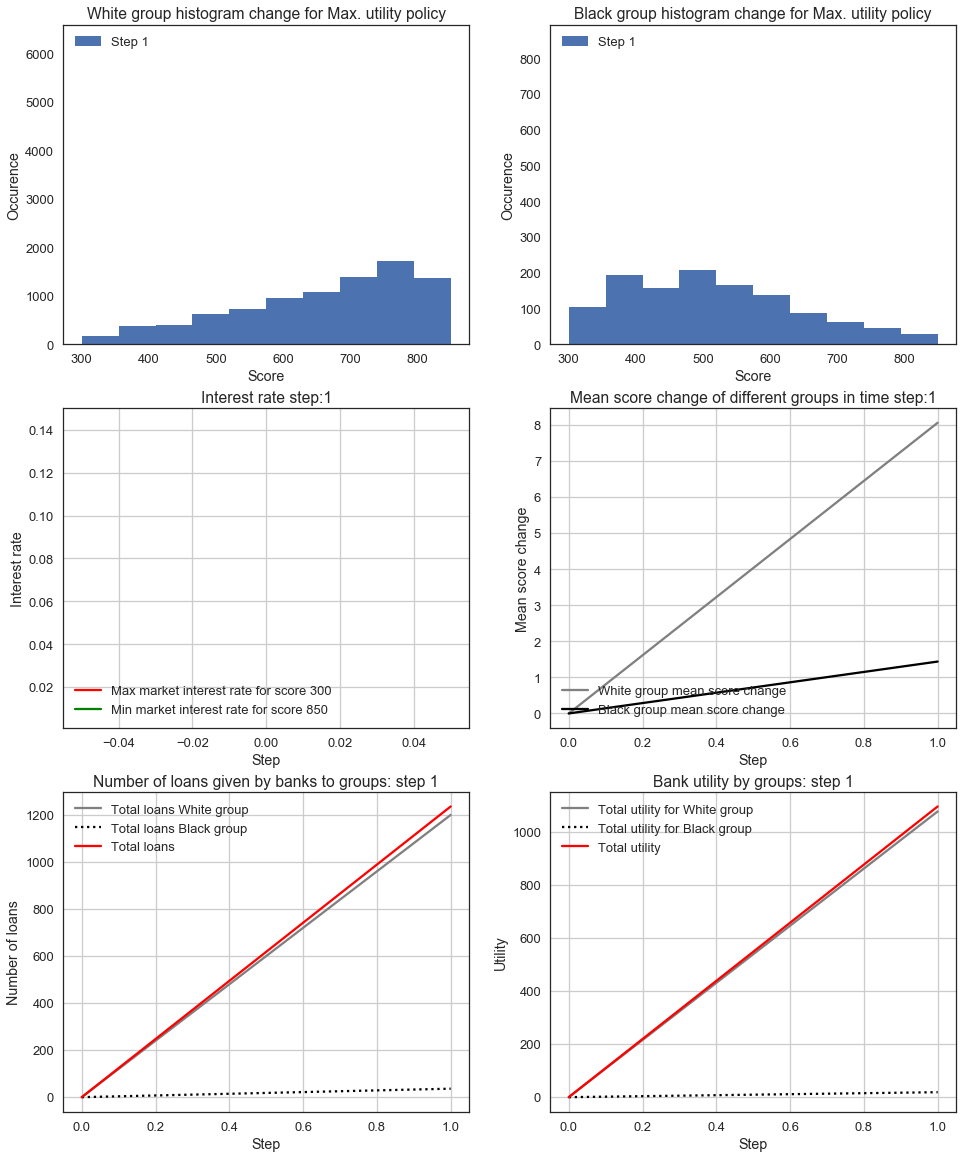

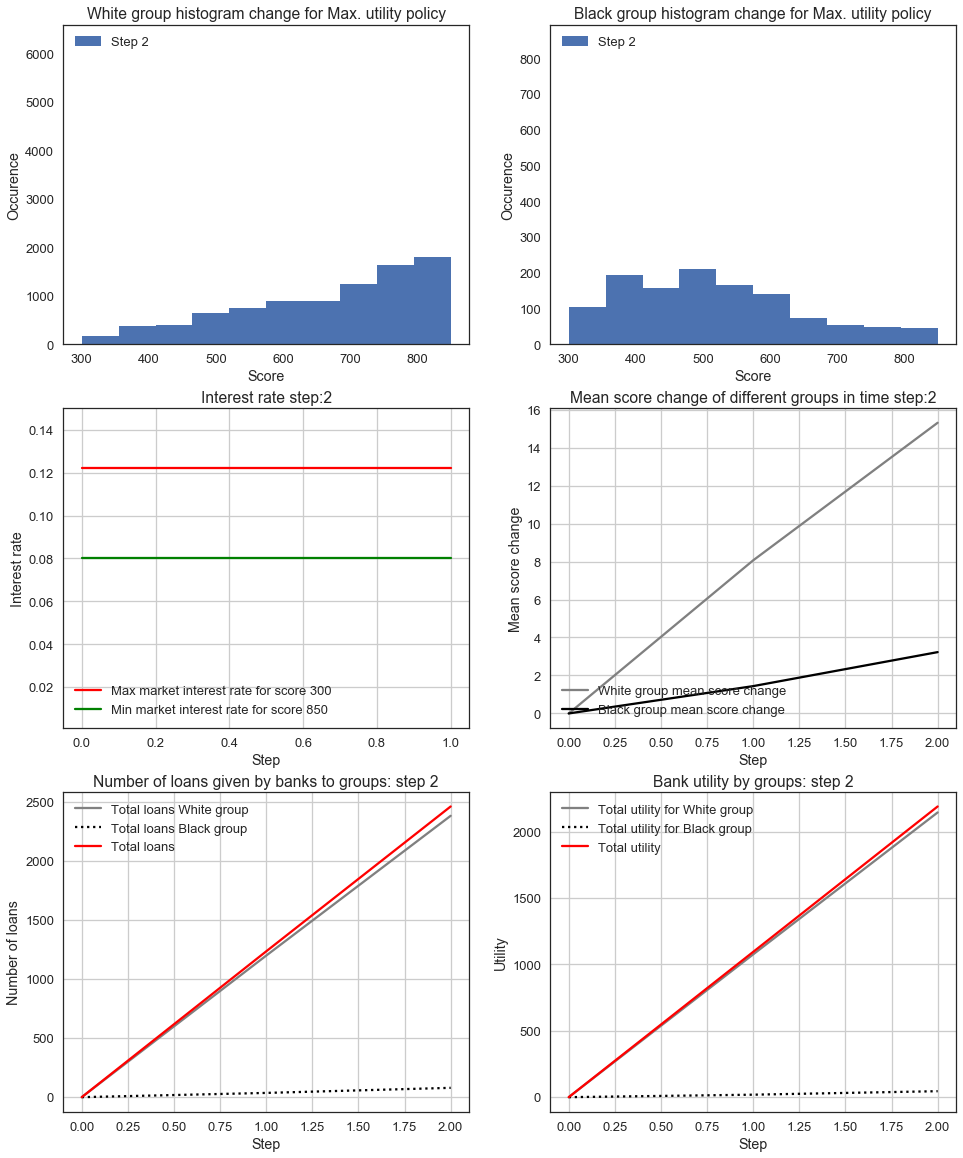

In [34]:
for time in range(0, time_steps):
    utilities = {}
    utility_curves = {}
    N_loans = {}
    step_loans = 0
    step_customers = 0
    
    ### Before ###
    #compute what selection rate will be the best to select
    best_util = 0
    best_slice = 0
    best_selection_rates = {}
    plane_slices = np.arange(plane_range[0], plane_range[1]+plane_slice_step , plane_slice_step)
    for pslice in plane_slices:
        interest_rate_slice = market.interest_rate_plane[str(pslice)]
        for bank in banks:
            bank.change_interest_rate_range(interest_rate_slice, market)
        selection_rates, max_util = market.get_selection_rate(banks, groups)
        util = 0
        for bank in banks:
            util += max_util[bank.name]
        print(util*pslice, pslice)
        if util*pslice > best_util:
            best_util = util*pslice
            best_slice = pslice
            best_selection_rates = selection_rates
    
    
    #set demand as the slice with max util
    for group in groups:
        group.loan_demand = best_slice
        print(group.loan_demand)
    #set market interest rate according to slice with max util
    interest_rate_slice = market.interest_rate_plane[str(best_slice)]
    for bank in banks:
        bank.change_interest_rate_range(interest_rate_slice, market)
        
    market.max_irates.append(interest_rate_slice[market.score_range[0]])
    market.min_irates.append(interest_rate_slice[market.score_range[1]])
    
    #set selection rates
    for bank in banks:
        bank.set_selection_rate(best_selection_rates[bank.name])
        utilities[bank.name] = {}
        utility_curves[bank.name] = {}
        N_loans[bank.name] = {}

    ### During ###
    for group in groups:
        for bank in banks:
            utilities[bank.name][group.name] = 0
            utility_curves[bank.name][group.name] = []
            N_loans[bank.name][group.name] = 0
            
        #select part of customer base at random according to group loan demand
        customers = np.sort(random.sample(range(0, group.size), int(group.size*group.loan_demand)))
        print(customers)
        step_customers += len(customers) 
        #go over all selected customers in the group
        for j in customers:
            selected_bank = None
            bank_select_order = random.sample(range(0, len(banks)), len(banks))
            
            # check banks at random if they give loan to customer j
            for k in bank_select_order:
                if j/group.size <= banks[k].group_selection_rate[group.name]:
                    selected_bank = k
                    step_loans += 1
                    total_loans[group.name] += 1
                    break

            if selected_bank is not None:
                #get loan outcome and change score
                N_loans[banks[selected_bank].name][group.name] += 1 
                real_customer_score = group.real_scores[j]
                loan_outcome = group.get_repay_outcome(group.score_repay_prob[real_customer_score])
                group.change_score(market, j, loan_outcome)
                group.change_real_score(market, j, loan_outcome)
                
                #get bank utility
                interest_rate = banks[selected_bank].score_interest_rates[group.scores[j]]
                utility_change = banks[selected_bank].get_customer_utility(interest_rate, loan_outcome)
                utilities[banks[selected_bank].name][group.name] += utility_change
                total_utility[group.name] += utility_change
                utility_curves[banks[selected_bank].name][group.name].append(utilities[banks[selected_bank].name][group.name])
        
        for bank in banks:
            if market.step == 0:
                bank.N_loan_curves[group.name].append(N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(utilities[bank.name][group.name])
            else:
                bank.N_loan_curves[group.name].append(bank.N_loan_curves[group.name][-1] + N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(bank.total_utility_curves[group.name][-1] + utilities[bank.name][group.name])        
        group.sort_scores()
        group_mean_score_change_curve[group.name].append(group.get_mean_score_change())
        print(group.name + " group mean score: " + str(group.get_mean_score_change())+ " at step: " + str(market.step+1))
    
    market.step += 1 
    
    ### After ###    
    for group in groups:
        market.loans[group.name].append(total_loans[group.name])
        market.utility[group.name].append(total_utility[group.name])
    
    market.plot_market_situation_PC(banks, groups, group_mean_score_change_curve)

# Playing with TC, TR, MC, MR and UC

5944
1718.5770373 1709.40532594
1696.7232 1728.6336


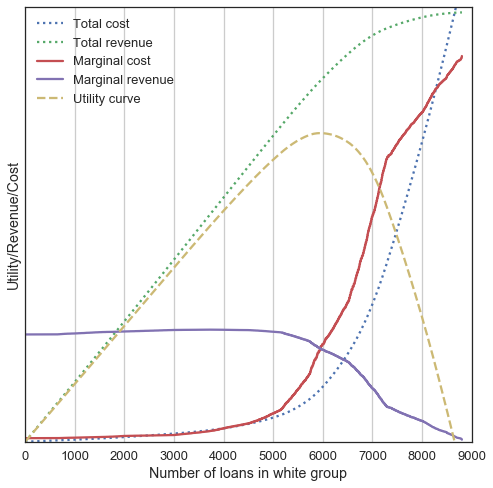

In [7]:
TC_curve = [0]
TR_curve = [0]
MC_curve = []
MR_curve = []
utility_curve = []
TC=0
TR=0
utility=0

n=0

for k in range(0, groups[n].size):
    expected_customer_score = banks[0].get_expected_customer_score(market,groups[n].scores[k])
    utility += banks[0].get_customer_evaluation_utility(expected_customer_score, groups[n])
    utility_curve.append(utility*1)
    TC += -banks[0].utility_default*(1-groups[n].score_repay_prob[expected_customer_score])
    TR += (banks[0].utility_repaid+banks[0].score_interest_rates[expected_customer_score])*groups[n].score_repay_prob[expected_customer_score]
    TC_curve.append(TC)
    TR_curve.append(TR)
    MC_curve.append((TC_curve[-1] - TC_curve[-2])*1800)
    MR_curve.append((TR_curve[-1] - TR_curve[-2])*1800)
    
plt.figure(figsize=(8,8))
plt.plot(list(range(0, len(TC_curve))),TC_curve,LineStyle=":",label="Total cost")
plt.plot(list(range(0, len(TR_curve))),TR_curve,LineStyle=":",label="Total revenue")
plt.plot(list(range(0, len(MC_curve))),MC_curve,label="Marginal cost")
plt.plot(list(range(0, len(MR_curve))),MR_curve,label="Marginal revenue")
plt.plot(list(range(0, len(utility_curve))),utility_curve,LineStyle="--",label="Utility curve")
plt.xlabel("Number of loans in white group")
plt.ylabel("Utility/Revenue/Cost")
plt.ylim(0,8000)
plt.xlim(0,9000)
plt.yticks([])
plt.grid("on")
plt.legend()
plt.show

print(utility_curve.index(max(utility_curve)))
i =utility_curve.index(max(utility_curve))
print(MR_curve[i],MR_curve[i+1])
print(MC_curve[i],MC_curve[i+1])

# Perfect competition market

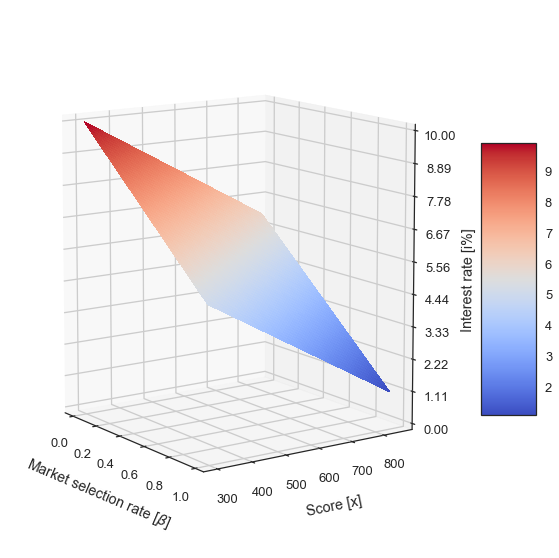

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 1, 0.01)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 5-X*5 + 5-((Y-300)/550)*4 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Market selection rate [$\beta$]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=10., azim=-35)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Imperfect competition cartel market

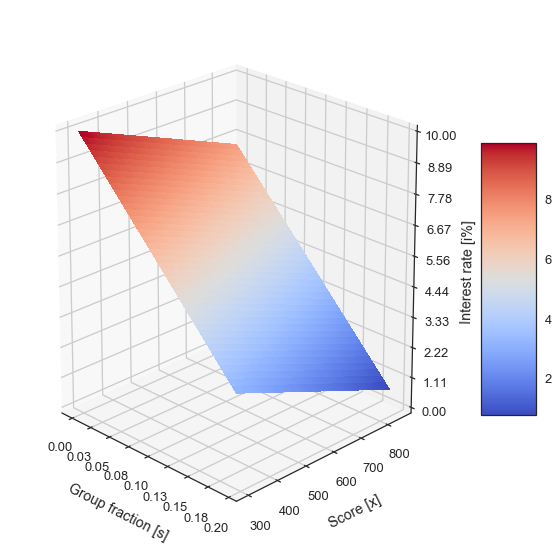

In [9]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 0.2, 0.005)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 7-X*35 + 3 - ((Y-300)/550)*2.5 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Group fraction [s]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=20, azim=-45)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()